# Installation

- OpenAI

In [1]:
!pip install openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.9/362.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.4 MB/s eta 0:00:00


# Setup Credential

After creating Azure OpenAI Service, You can these credential in Azure OpenAI Console

| Variable  |  Value |
|---|---|
| AZURE_OPENAI_API_KEY  | This value can be found in the Keys & Endpoint section when examining your resource from the Azure portal. Alternatively, you can find the value in the Azure OpenAI Studio > Playground > Code View. An example endpoint is: https://docs-test-001.openai.azure.com/.  |
|  AZURE_ENDPOINT |  This value can be found in the Keys & Endpoint section when examining your resource from the Azure portal. You can use either KEY1 or KEY2. |
|  AZURE_OPENAI_MODEL_VERSION | Deployed Model Version  |

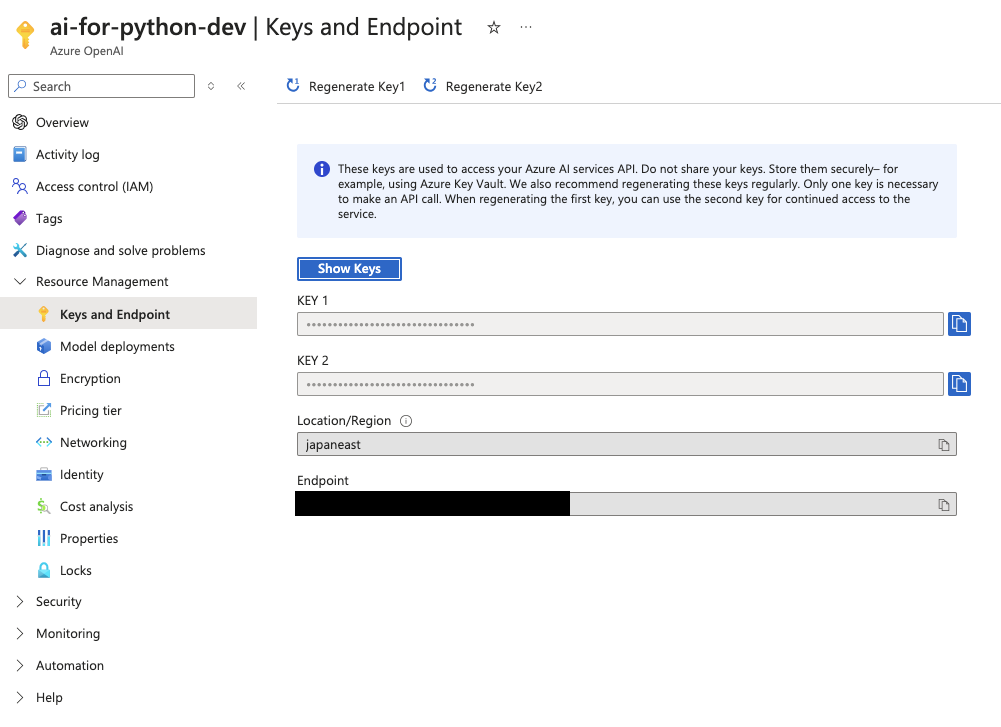

In [34]:
AZURE_OPENAI_API_KEY= "" # Azure OpenAI API Key
AZURE_OPENAI_MODEL_VERSION = "" # Deployed Model Version
AZURE_ENDPOINT = "" # Deployed Model Endpoint
AZURE_OPENAI_MODEL_DEPLOYMENT = "" # Deployed Model Name

# Let's Play

### Initiate connection to Azure OpenAI Service

In [65]:
# Import AzureOpenAI
from openai import AzureOpenAI
import json

In [36]:
client = AzureOpenAI(
    api_key=AZURE_OPENAI_API_KEY,
    api_version=AZURE_OPENAI_MODEL_VERSION,
    azure_endpoint=AZURE_ENDPOINT,
)

### Create pre-defined prompt

In [37]:
prompts = [
    {"role": "system", "content": "You are a helpful assistant."},
]

### Define user message



In [46]:
user_message = "List the AI services in Azure"

##### Wrap prompts and user message

In [47]:
messages = []
for prompt in prompts:
  messages.append(prompt)

# inject user message
messages.append({
    "role": "user",
    "content": user_message
})

Send request to OpenAI Model

In [48]:
response = client.chat.completions.create(
    model=AZURE_OPENAI_MODEL_DEPLOYMENT,
    messages=messages,
)

In [49]:
response.choices[0].message.content

'Sure! Here are some of the AI services available in Azure:\n\n1. Azure Cognitive Services: This suite of services includes a wide range of AI capabilities such as vision, speech, knowledge, and language processing. Some services in this suite include Computer Vision, Speech to Text, Text Analytics, and Translator Text.\n\n2. Azure Machine Learning: This service enables you to build, deploy, and manage machine learning models at scale. It provides tools and frameworks for data exploration, model training, and model deployment.\n\n3. Azure Bot Service: This service allows you to build, deploy, and manage intelligent chatbots using pre-built AI models or custom models. It provides integration with various channels like web, mobile, and messaging platforms.\n\n4. Azure Custom Vision: This service enables you to build custom image classification and object detection models using your own labeled images. It uses transfer learning to simplify the model creation process.\n\n5. Azure Form Reco

## Function Call

We can let LLMs decide to call function.
Ref: https://platform.openai.com/docs/guides/function-calling

In [50]:
# Mock Data
server_log_data = [
    {
      "server_name": "AWS-01",
      "message": "OK",
      "status": 200,
    },
    {
        "server_name": "Azure-01",
        "message": "Created",
        "status": 201
    },
    {
        "server_name": "GCP-02",
        "message": "Done",
        "status": 202
    },
    {
        "server_name": "unknown",
        "message": "Error",
        "status": 400
    }
  ]

In [67]:
# get status
def get_server_log(status):
  if(status is None):
    print("status is None")
    return []

  data = list(filter(lambda log: log['status'] == status, server_log_data))

  return data

Define function for OpenAI Model

In [52]:
tools = [{
    "type": "function",
    "function": {
      "name": "get_server_log",
      "description": "Get server log, logging, by status, Call this whenever you know status code.",
      "parameters": {
          "type": "object",
          "properties": {
              "status": {
                  "type": "number",
                  "description": "Status code",
              },
          },
          "required": ["order_id"]
      }
    }
}]

In [55]:
prompts = [
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "system", "content": "good status are 200, 201, 202. bad status is 400."}
]

In [92]:
# Let change this
user_message = "Fetch status of 201 in our server log."

In [93]:
messages = []
for prompt in prompts:
  messages.append(prompt)

# inject user message
messages.append({
    "role": "user",
    "content": user_message
})

In [94]:
response = client.chat.completions.create(
    model=AZURE_OPENAI_MODEL_DEPLOYMENT,
    messages=messages,
    tools=tools,
    tool_choice="required"
)

In [99]:
result = ""
for tool_call in response.choices[0].message.tool_calls:
  arguments = json.loads(tool_call.function.arguments)
  status = arguments['status']
  result = get_server_log(status)

In [108]:
prompts = [
    {"role": "system", "content": "You are a technical assistant."},
    {"role": "system", "content": "You always humanize all messages."},
    {"role": "system", "content": "If you receive JSON or Array of server logging, Please summarize it to DevOps engineer."}
]

In [109]:
to_summary_message = json.dumps(result)

In [110]:
messages = []
for prompt in prompts:
  messages.append(prompt)

# inject user message
messages.append({
    "role": "user",
    "content": to_summary_message
})

In [111]:
response = client.chat.completions.create(
    model=AZURE_OPENAI_MODEL_DEPLOYMENT,
    messages=messages,
)

In [113]:
response.choices[0].message.content

'Summary: \nServer "Azure-01" was created successfully with a status code of 201.'